### 1. 필요한 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

### 2. 전처리한 데이터 불러오기 및 데이터 확인

In [2]:
df = pd.read_csv('./data/result_final.csv', parse_dates=['baseYmd'])
df

,areaNm,touNum,baseYmd,avgTemp,dayRf,daySf,festival,holiday,PM10,PM25,AccumulateCovid19,increase,localIncrease,CovidForeigner
0,서울특별시,1171117.50,2022-01-01,-4.3,no,no,no,yes,no,no,226698.0,1464.0,1429.0,35.0
1,부산광역시,445102.00,2022-01-01,1.9,no,no,no,yes,no,no,25287.0,212.0,210.0,2.0
2,대구광역시,264113.50,2022-01-01,-2.3,no,no,no,yes,no,no,23249.0,125.0,125.0,0.0
3,인천광역시,496692.00,2022-01-01,-3.4,no,no,no,yes,no,no,36962.0,241.0,239.0,2.0
4,광주광역시,161028.00,2022-01-01,-0.1,no,no,no,yes,no,no,8118.0,92.0,91.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,전라북도,221235.00,2022-09-03,25.3,no,no,yes,yes,no,no,788103.0,3442.0,3431.0,11.0
6201,전라남도,304470.25,2022-09-03,24.1,yes,no,yes,yes,no,no,776823.0,3048.0,3041.0,7.0
6202,경상북도,425582.50,2022-09-03,21.0,yes,no,no,yes,no,no,1042687.0,4782.0,4753.0,29.0
6203,경상남도,363550.25,2022-09-03,21.0,yes,no,no,yes,no,no,1406209.0,5373.0,5362.0,11.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6205 entries, 0 to 6204
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   areaNm             6205 non-null   object        
 1   touNum             6205 non-null   float64       
 2   baseYmd            6205 non-null   datetime64[ns]
 3   avgTemp            6205 non-null   float64       
 4   dayRf              6205 non-null   object        
 5   daySf              6205 non-null   object        
 6   festival           6205 non-null   object        
 7   holiday            6205 non-null   object        
 8   PM10               6205 non-null   object        
 9   PM25               6205 non-null   object        
 10  AccumulateCovid19  6205 non-null   float64       
 11  increase           6205 non-null   float64       
 12  localIncrease      6205 non-null   float64       
 13  CovidForeigner     6205 non-null   float64       
dtypes: datet

In [4]:
# 범주형변수 정규화
df_festival = pd.get_dummies(df['festival'], prefix='festival')
df = pd.concat([df, df_festival], axis=1)
df_holiday = pd.get_dummies(df['holiday'], prefix='holiday')
df = pd.concat([df, df_holiday], axis=1)
df_PM10 = pd.get_dummies(df['PM10'], prefix='PM10')
df = pd.concat([df, df_PM10], axis=1)
df_PM25 = pd.get_dummies(df['PM25'], prefix='PM25')
df = pd.concat([df, df_PM25], axis=1)
df_dayRf = pd.get_dummies(df['dayRf'], prefix='dayRf')
df = pd.concat([df, df_dayRf], axis=1)
df.drop(columns=['festival', 'holiday', 'PM10', 'PM25', 'dayRf', 'daySf'], inplace=True)
df

,areaNm,touNum,baseYmd,avgTemp,AccumulateCovid19,increase,localIncrease,CovidForeigner,festival_no,festival_yes,holiday_no,holiday_yes,PM10_no,PM10_yes,PM25_no,PM25_yes,dayRf_no,dayRf_yes
0,서울특별시,1171117.50,2022-01-01,-4.3,226698.0,1464.0,1429.0,35.0,1,0,0,1,1,0,1,0,1,0
1,부산광역시,445102.00,2022-01-01,1.9,25287.0,212.0,210.0,2.0,1,0,0,1,1,0,1,0,1,0
2,대구광역시,264113.50,2022-01-01,-2.3,23249.0,125.0,125.0,0.0,1,0,0,1,1,0,1,0,1,0
3,인천광역시,496692.00,2022-01-01,-3.4,36962.0,241.0,239.0,2.0,1,0,0,1,1,0,1,0,1,0
4,광주광역시,161028.00,2022-01-01,-0.1,8118.0,92.0,91.0,1.0,1,0,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6200,전라북도,221235.00,2022-09-03,25.3,788103.0,3442.0,3431.0,11.0,0,1,0,1,1,0,1,0,1,0
6201,전라남도,304470.25,2022-09-03,24.1,776823.0,3048.0,3041.0,7.0,0,1,0,1,1,0,1,0,0,1
6202,경상북도,425582.50,2022-09-03,21.0,1042687.0,4782.0,4753.0,29.0,1,0,0,1,1,0,1,0,0,1
6203,경상남도,363550.25,2022-09-03,21.0,1406209.0,5373.0,5362.0,11.0,1,0,0,1,1,0,1,0,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6205 entries, 0 to 6204
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   areaNm             6205 non-null   object        
 1   touNum             6205 non-null   float64       
 2   baseYmd            6205 non-null   datetime64[ns]
 3   avgTemp            6205 non-null   float64       
 4   AccumulateCovid19  6205 non-null   float64       
 5   increase           6205 non-null   float64       
 6   localIncrease      6205 non-null   float64       
 7   CovidForeigner     6205 non-null   float64       
 8   festival_no        6205 non-null   uint8         
 9   festival_yes       6205 non-null   uint8         
 10  holiday_no         6205 non-null   uint8         
 11  holiday_yes        6205 non-null   uint8         
 12  PM10_no            6205 non-null   uint8         
 13  PM10_yes           6205 non-null   uint8         
 14  PM25_no 

### 3. 임의의 지역을 각각의 샘플로 저장

In [6]:
# 분류하여 각 변수에 저장
df_seoul = df.loc[df['areaNm'] == '서울특별시']
df_jeju = df.loc[df['areaNm'] == '제주특별자치도']
df_gangwon = df.loc[df['areaNm'] == '강원도']
df_jeonju = df.loc[df['areaNm'] == '전라남도']
df_busan = df.loc[df['areaNm'] == '부산광역시']
df_chungju = df.loc[df['areaNm'] == '충청북도']


In [7]:
# 분류된 광역시 컬럼 삭제
df_seoul.drop(columns=['areaNm'], inplace=True)
df_jeju.drop(columns=['areaNm'], inplace=True)
df_gangwon.drop(columns=['areaNm'], inplace=True)
df_jeonju.drop(columns=['areaNm'], inplace=True)
df_busan.drop(columns=['areaNm'], inplace=True)
df_chungju.drop(columns=['areaNm'], inplace=True)

### 4. 각 샘플 데이터 확인

- 서울특별시

In [8]:
df_seoul.columns

Index(['touNum', 'baseYmd', 'avgTemp', 'AccumulateCovid19', 'increase',
       'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes',
       'holiday_no', 'holiday_yes', 'PM10_no', 'PM10_yes', 'PM25_no',
       'PM25_yes', 'dayRf_no', 'dayRf_yes'],
      dtype='object')

In [9]:
df_seoul_col = df_seoul.drop(columns=['baseYmd', 'dayRf_yes', 'dayRf_no', 'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes'])

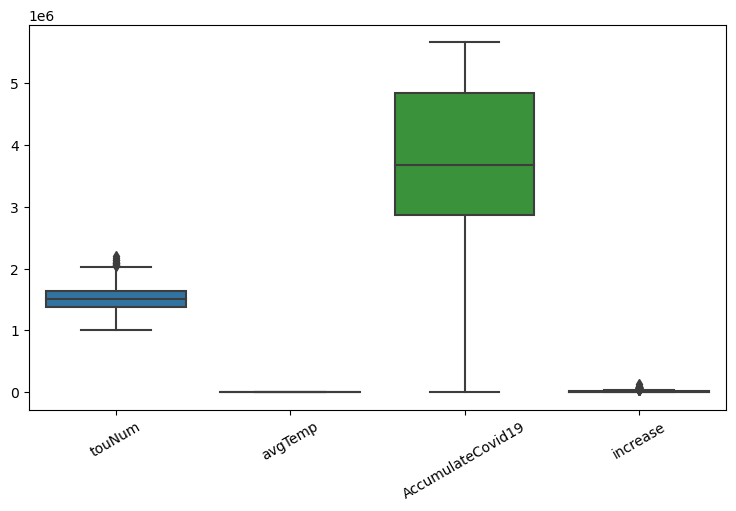

In [10]:
# 스케일링 전
plt.figure(figsize=(9, 5))
df_box = sns.boxplot(data=df_seoul_col)
df_box.set_xticklabels(df_box.get_xticklabels(), rotation=30)
plt.show()

In [11]:
scaler = RobustScaler()
df_seoul_scaling = scaler.fit_transform(df_seoul_col)
df_seoul_scaled = pd.DataFrame(df_seoul_scaling, columns=df_seoul_col.columns)
df_seoul_scaled

,touNum,avgTemp,AccumulateCovid19,increase
0,-1.263418,-1.067039,-1.742354,-0.536985
1,-1.484053,-0.899441,-1.741756,-0.557812
2,-1.651579,-0.932961,-1.741257,-0.571894
3,-1.402199,-0.966480,-1.740784,-0.575971
4,-1.246100,-0.983240,-1.740070,-0.540839
...,...,...,...,...
360,0.000000,0.603352,0.304337,-0.034317
361,0.000000,0.625698,0.304337,-0.034317
362,0.000000,0.748603,0.304337,-0.034317
363,0.000000,0.553073,0.456899,0.342129


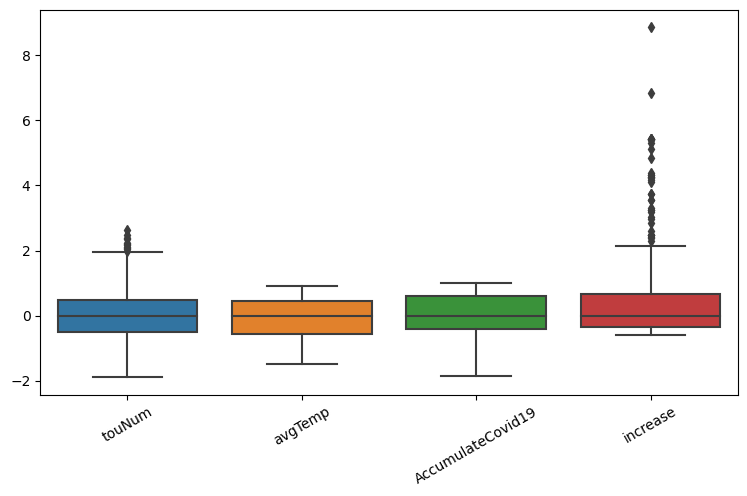

In [12]:
# 스케일링 후
plt.figure(figsize=(9, 5))
df_box2 = sns.boxplot(data=df_seoul_scaled)
df_box2.set_xticklabels(df_box2.get_xticklabels(), rotation=30)
plt.show()

In [13]:
# 이상치 대체 함수
def replace_outliers_median(data, threshold=1):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    data[z_scores >= threshold] = np.median(data)
    return data
df_seoul_outlier = replace_outliers_median(df_seoul_scaled)

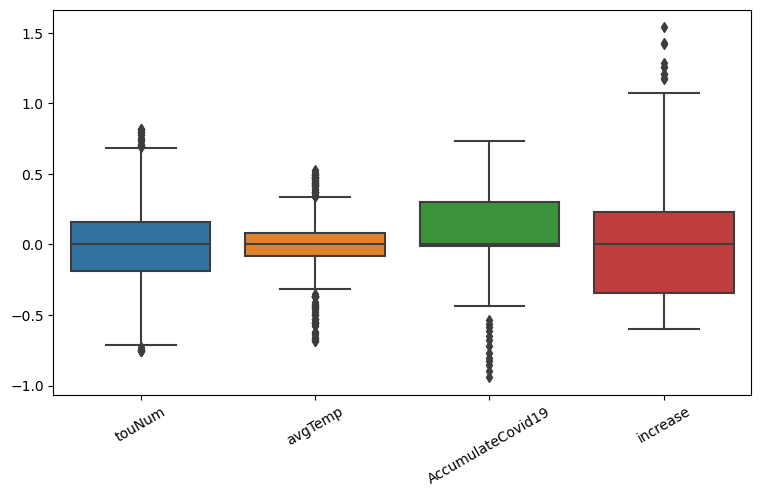

In [14]:
# 이상치 대체
plt.figure(figsize=(9, 5))
df_box3 = sns.boxplot(data=df_seoul_outlier)
df_box3.set_xticklabels(df_box3.get_xticklabels(), rotation=30)
plt.show()

In [15]:
df_seoul_outlier

,touNum,avgTemp,AccumulateCovid19,increase
0,0.0,0.00000,0.000000,-0.536985
1,0.0,0.00000,0.000000,-0.557812
2,0.0,0.00000,0.000000,-0.571894
3,0.0,0.00000,0.000000,-0.575971
4,0.0,0.00000,0.000000,-0.540839
...,...,...,...,...
360,0.0,0.00000,0.304337,-0.034317
361,0.0,0.00000,0.304337,-0.034317
362,0.0,0.00000,0.304337,-0.034317
363,0.0,0.00000,0.456899,0.342129


In [16]:
df_seoul_drop = df_seoul.drop(columns= ['touNum', 'avgTemp', 'AccumulateCovid19', 'increase', 'localIncrease', 'CovidForeigner'])
df_seoul_drop.set_index([pd.Index(range(0, 365))], inplace=True)
df_seoul = pd.concat([df_seoul_outlier, df_seoul_drop], axis=1)
df_seoul.to_csv('./data/df_seoul_final.csv', index=False, encoding='utf-8')
df_seoul

,touNum,avgTemp,AccumulateCovid19,increase,baseYmd,festival_no,festival_yes,holiday_no,holiday_yes,PM10_no,PM10_yes,PM25_no,PM25_yes,dayRf_no,dayRf_yes
0,0.0,0.00000,0.000000,-0.536985,2022-01-01,1,0,0,1,1,0,1,0,1,0
1,0.0,0.00000,0.000000,-0.557812,2022-01-02,1,0,0,1,1,0,1,0,0,1
2,0.0,0.00000,0.000000,-0.571894,2022-01-03,1,0,1,0,1,0,1,0,1,0
3,0.0,0.00000,0.000000,-0.575971,2022-01-04,1,0,1,0,1,0,1,0,1,0
4,0.0,0.00000,0.000000,-0.540839,2022-01-05,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.0,0.00000,0.304337,-0.034317,2022-08-18,1,0,1,0,1,0,1,0,1,0
361,0.0,0.00000,0.304337,-0.034317,2022-08-19,1,0,1,0,1,0,1,0,0,1
362,0.0,0.00000,0.304337,-0.034317,2022-08-20,1,0,0,1,1,0,1,0,1,0
363,0.0,0.00000,0.456899,0.342129,2022-09-02,1,0,1,0,1,0,1,0,1,0


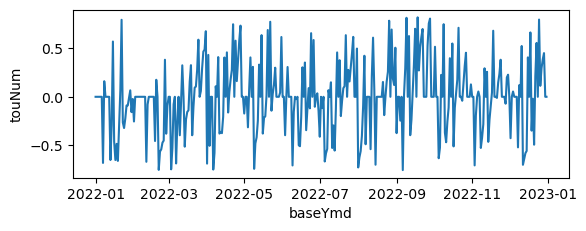

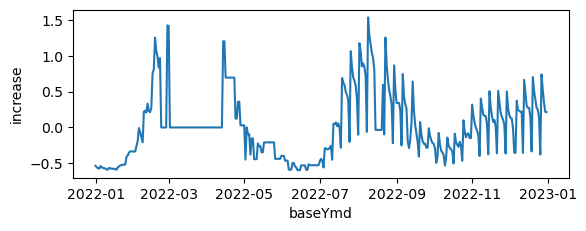

In [17]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_seoul['baseYmd'], y=df_seoul['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_seoul['baseYmd'], y=df_seoul['increase'])
plt.show()

- 제주특별자치도

In [18]:
df_jeju.columns

Index(['touNum', 'baseYmd', 'avgTemp', 'AccumulateCovid19', 'increase',
       'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes',
       'holiday_no', 'holiday_yes', 'PM10_no', 'PM10_yes', 'PM25_no',
       'PM25_yes', 'dayRf_no', 'dayRf_yes'],
      dtype='object')

In [19]:
df_jeju_col = df_jeju.drop(columns=['baseYmd', 'dayRf_yes', 'dayRf_no', 'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes'])

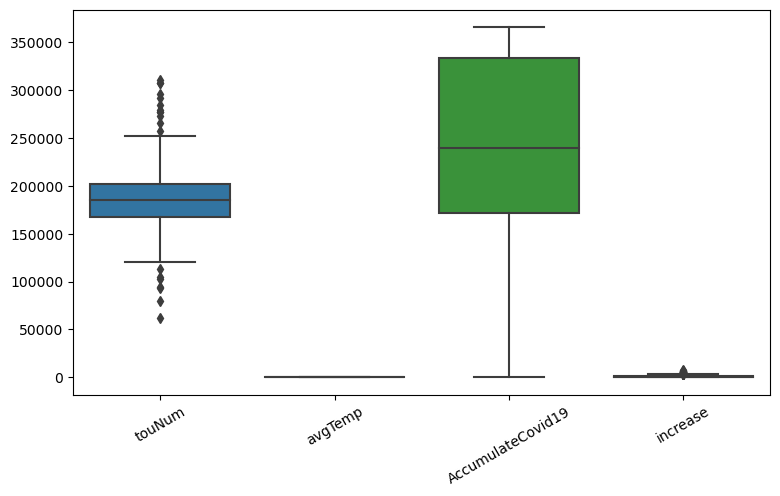

In [20]:
# 스케일링 전
plt.figure(figsize=(9, 5))
df_box = sns.boxplot(data=df_jeju_col)
df_box.set_xticklabels(df_box.get_xticklabels(), rotation=30)
plt.show()

In [21]:
scaler = RobustScaler()
df_jeju_scaling = scaler.fit_transform(df_jeju_col)
df_jeju_scaled = pd.DataFrame(df_jeju_scaling, columns=df_jeju_col.columns)
df_jeju_scaled

,touNum,avgTemp,AccumulateCovid19,increase
0,-0.241688,-0.872340,-1.449431,-0.321549
1,-0.446403,-0.709220,-1.449314,-0.324916
2,-0.737860,-0.794326,-1.449141,-0.317340
3,-0.825307,-0.737589,-1.449030,-0.325758
4,-0.718719,-0.808511,-1.448765,-0.304714
...,...,...,...,...
360,0.000000,0.730496,0.346350,0.898990
361,0.000000,0.971631,0.346350,0.898990
362,0.000000,0.858156,0.346350,0.898990
363,0.000000,0.425532,0.509661,0.540404


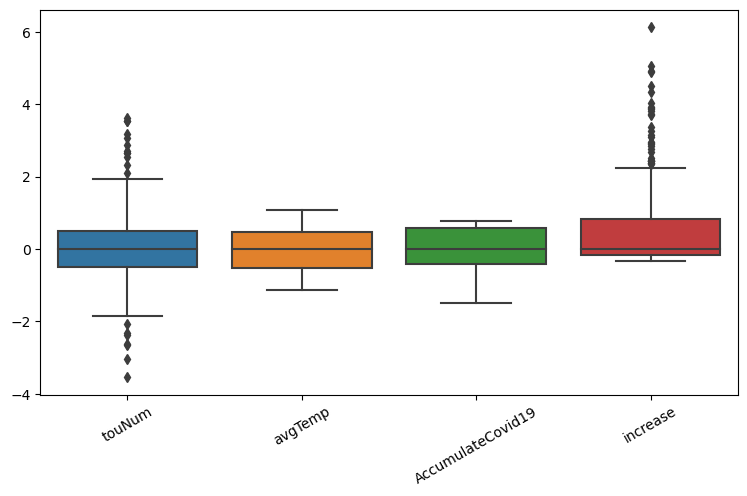

In [22]:
# 스케일링 후
plt.figure(figsize=(9, 5))
df_box2 = sns.boxplot(data=df_jeju_scaled)
df_box2.set_xticklabels(df_box2.get_xticklabels(), rotation=30)
plt.show()

In [23]:
# 이상치 대체 함수
def replace_outliers_median(data, threshold=1):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    data[z_scores >= threshold] = np.median(data)
    return data
df_jeju_outlier = replace_outliers_median(df_jeju_scaled)

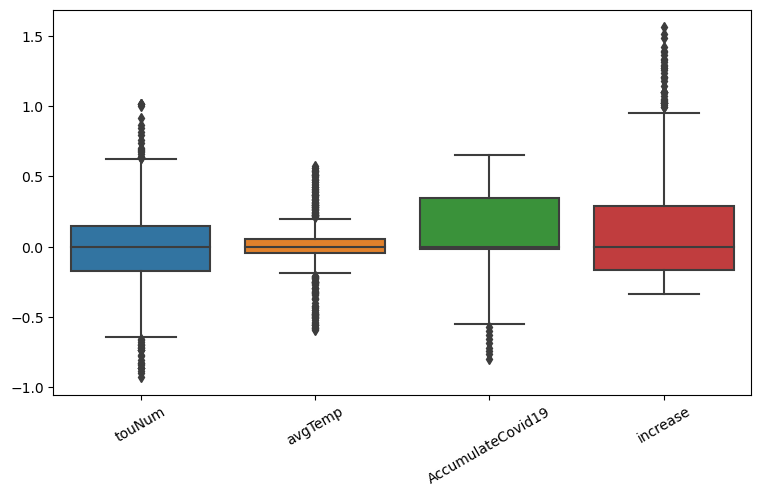

In [24]:
# 이상치 대체
plt.figure(figsize=(9, 5))
df_box3 = sns.boxplot(data=df_jeju_outlier)
df_box3.set_xticklabels(df_box3.get_xticklabels(), rotation=30)
plt.show()

In [25]:
df_jeju_outlier

,touNum,avgTemp,AccumulateCovid19,increase
0,-0.241688,0.000000,0.000000,-0.321549
1,-0.446403,0.000000,0.000000,-0.324916
2,-0.737860,0.000000,0.000000,-0.317340
3,-0.825307,0.000000,0.000000,-0.325758
4,-0.718719,0.000000,0.000000,-0.304714
...,...,...,...,...
360,0.000000,0.000000,0.346350,0.898990
361,0.000000,0.000000,0.346350,0.898990
362,0.000000,0.000000,0.346350,0.898990
363,0.000000,0.425532,0.509661,0.540404


In [26]:
df_jeju_drop = df_jeju.drop(columns= ['touNum', 'avgTemp', 'AccumulateCovid19', 'increase', 'localIncrease', 'CovidForeigner'])
df_jeju_drop.set_index([pd.Index(range(0, 365))], inplace=True)
df_jeju = pd.concat([df_jeju_outlier, df_jeju_drop], axis=1)
df_jeju.to_csv('./data/df_jeju_final.csv', index=False, encoding='utf-8')
df_jeju

,touNum,avgTemp,AccumulateCovid19,increase,baseYmd,festival_no,festival_yes,holiday_no,holiday_yes,PM10_no,PM10_yes,PM25_no,PM25_yes,dayRf_no,dayRf_yes
0,-0.241688,0.000000,0.000000,-0.321549,2022-01-01,1,0,0,1,1,0,1,0,1,0
1,-0.446403,0.000000,0.000000,-0.324916,2022-01-02,1,0,0,1,1,0,1,0,1,0
2,-0.737860,0.000000,0.000000,-0.317340,2022-01-03,1,0,1,0,1,0,1,0,1,0
3,-0.825307,0.000000,0.000000,-0.325758,2022-01-04,1,0,1,0,1,0,1,0,1,0
4,-0.718719,0.000000,0.000000,-0.304714,2022-01-05,1,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.000000,0.000000,0.346350,0.898990,2022-08-18,1,0,1,0,1,0,1,0,1,0
361,0.000000,0.000000,0.346350,0.898990,2022-08-19,1,0,1,0,1,0,1,0,1,0
362,0.000000,0.000000,0.346350,0.898990,2022-08-20,1,0,0,1,1,0,1,0,1,0
363,0.000000,0.425532,0.509661,0.540404,2022-09-02,1,0,1,0,1,0,1,0,0,1


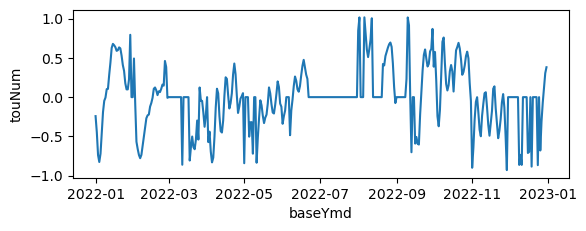

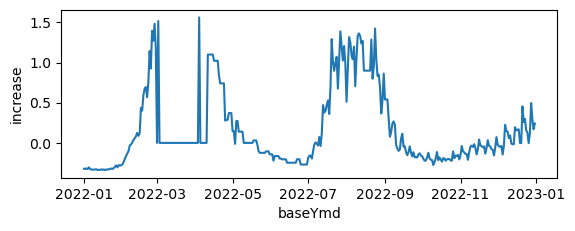

In [27]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_jeju['baseYmd'], y=df_jeju['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_jeju['baseYmd'], y=df_jeju['increase'])
plt.show()

- 강원도

In [28]:
df_gangwon.columns

Index(['touNum', 'baseYmd', 'avgTemp', 'AccumulateCovid19', 'increase',
       'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes',
       'holiday_no', 'holiday_yes', 'PM10_no', 'PM10_yes', 'PM25_no',
       'PM25_yes', 'dayRf_no', 'dayRf_yes'],
      dtype='object')

In [29]:
df_gangwon_col = df_gangwon.drop(columns=['baseYmd', 'dayRf_yes', 'dayRf_no', 'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes'])

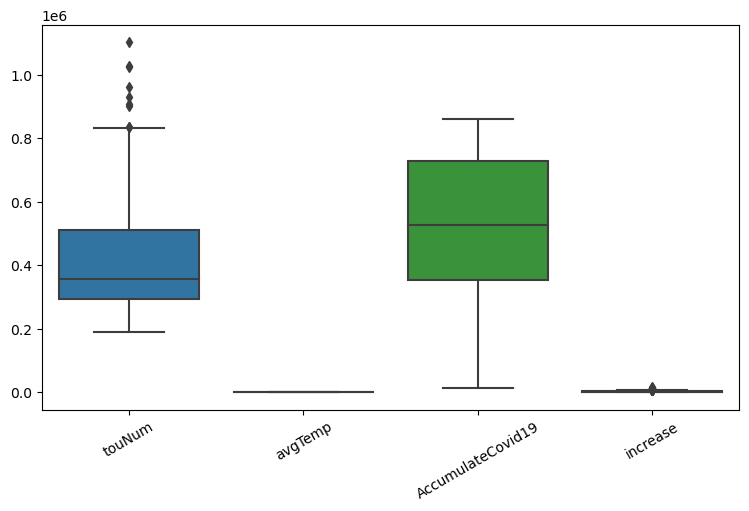

In [30]:
# 스케일링 전
plt.figure(figsize=(9, 5))
df_box = sns.boxplot(data=df_gangwon_col)
df_box.set_xticklabels(df_box.get_xticklabels(), rotation=30)
plt.show()

In [31]:
scaler = RobustScaler()
df_gangwon_scaling = scaler.fit_transform(df_gangwon_col)
df_gangwon_scaled = pd.DataFrame(df_gangwon_scaling, columns=df_gangwon_col.columns)
df_gangwon_scaled

,touNum,avgTemp,AccumulateCovid19,increase
0,1.464936,-1.089474,-1.369017,-0.731595
1,0.508209,-0.800000,-1.368860,-0.731595
2,-0.527502,-0.857895,-1.368716,-0.734151
3,-0.576350,-0.836842,-1.368548,-0.729550
4,-0.558236,-0.905263,-1.368364,-0.726483
...,...,...,...,...
360,0.000000,0.668421,0.258903,0.449387
361,0.000000,0.636842,0.258903,0.449387
362,0.000000,0.800000,0.258903,0.449387
363,0.000000,0.526316,0.413322,0.584867


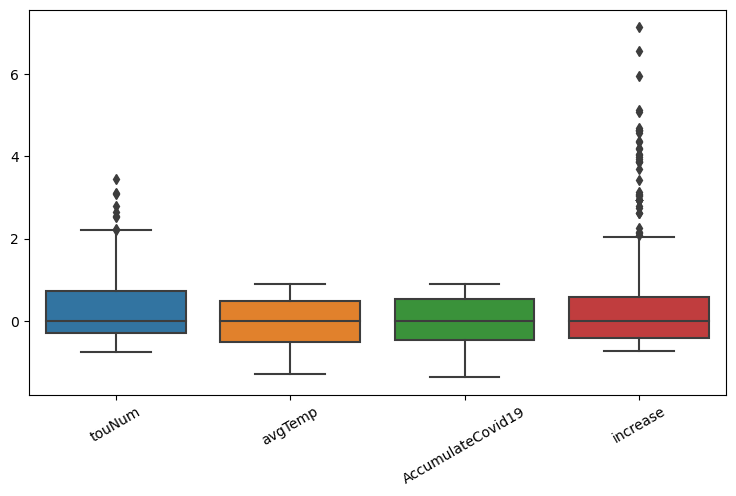

In [32]:
# 스케일링 후
plt.figure(figsize=(9, 5))
df_box2 = sns.boxplot(data=df_gangwon_scaled)
df_box2.set_xticklabels(df_box2.get_xticklabels(), rotation=30)
plt.show()

In [33]:
# 이상치 대체 함수
def replace_outliers_median(data, threshold=1):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    data[z_scores >= threshold] = np.median(data)
    return data
df_gangwon_outlier = replace_outliers_median(df_gangwon_scaled)

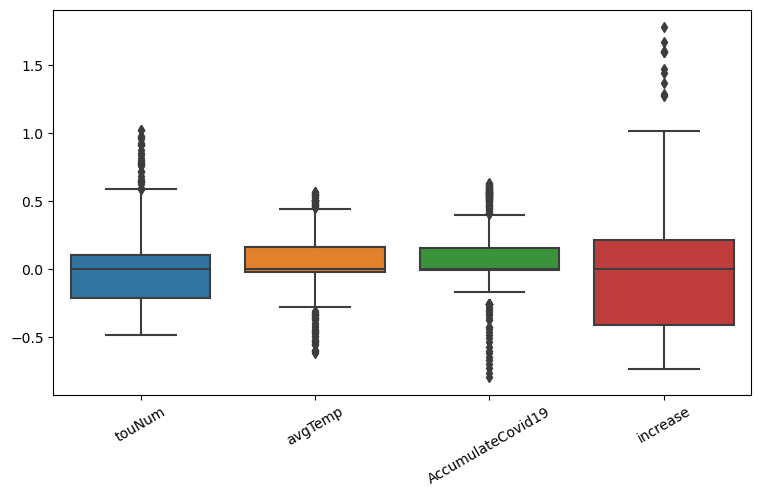

In [34]:
# 이상치 대체
plt.figure(figsize=(9, 5))
df_box3 = sns.boxplot(data=df_gangwon_outlier)
df_box3.set_xticklabels(df_box3.get_xticklabels(), rotation=30)
plt.show()

In [35]:
df_gangwon_outlier

,touNum,avgTemp,AccumulateCovid19,increase
0,0.000000,0.000000,0.000000,-0.731595
1,0.508209,0.000000,0.000000,-0.731595
2,0.000000,0.000000,0.000000,-0.734151
3,0.000000,0.000000,0.000000,-0.729550
4,0.000000,0.000000,0.000000,-0.726483
...,...,...,...,...
360,0.000000,0.000000,0.258903,0.449387
361,0.000000,0.000000,0.258903,0.449387
362,0.000000,0.000000,0.258903,0.449387
363,0.000000,0.526316,0.413322,0.584867


In [36]:
df_gangwon_drop = df_gangwon.drop(columns= ['touNum', 'avgTemp', 'AccumulateCovid19', 'increase', 'localIncrease', 'CovidForeigner'])
df_gangwon_drop.set_index([pd.Index(range(0, 365))], inplace=True)
df_gangwon = pd.concat([df_gangwon_outlier, df_gangwon_drop], axis=1)
df_gangwon.to_csv('./data/df_gangwon_final.csv', index=False, encoding='utf-8')
df_gangwon

,touNum,avgTemp,AccumulateCovid19,increase,baseYmd,festival_no,festival_yes,holiday_no,holiday_yes,PM10_no,PM10_yes,PM25_no,PM25_yes,dayRf_no,dayRf_yes
0,0.000000,0.000000,0.000000,-0.731595,2022-01-01,1,0,0,1,1,0,1,0,1,0
1,0.508209,0.000000,0.000000,-0.731595,2022-01-02,1,0,0,1,1,0,1,0,1,0
2,0.000000,0.000000,0.000000,-0.734151,2022-01-03,1,0,1,0,1,0,1,0,1,0
3,0.000000,0.000000,0.000000,-0.729550,2022-01-04,1,0,1,0,1,0,1,0,1,0
4,0.000000,0.000000,0.000000,-0.726483,2022-01-05,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.000000,0.000000,0.258903,0.449387,2022-08-18,1,0,1,0,1,0,1,0,1,0
361,0.000000,0.000000,0.258903,0.449387,2022-08-19,1,0,1,0,1,0,1,0,0,1
362,0.000000,0.000000,0.258903,0.449387,2022-08-20,1,0,0,1,1,0,1,0,1,0
363,0.000000,0.526316,0.413322,0.584867,2022-09-02,0,1,1,0,1,0,1,0,1,0


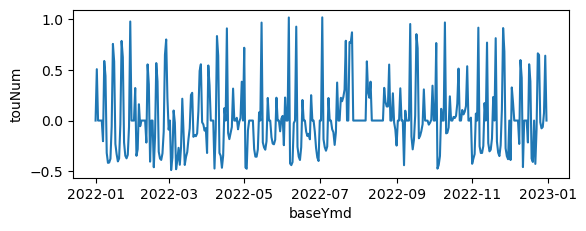

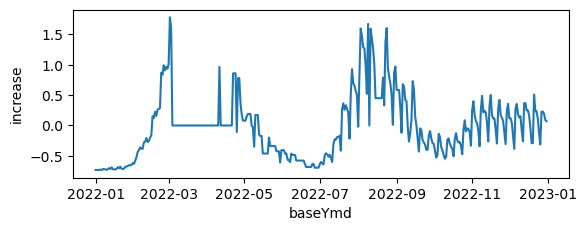

In [37]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_gangwon['baseYmd'], y=df_gangwon['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_gangwon['baseYmd'], y=df_gangwon['increase'])
plt.show()

- 전라남도

In [38]:
df_jeonju.columns

Index(['touNum', 'baseYmd', 'avgTemp', 'AccumulateCovid19', 'increase',
       'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes',
       'holiday_no', 'holiday_yes', 'PM10_no', 'PM10_yes', 'PM25_no',
       'PM25_yes', 'dayRf_no', 'dayRf_yes'],
      dtype='object')

In [39]:
df_jeonju_col = df_jeonju.drop(columns=['baseYmd', 'dayRf_yes', 'dayRf_no', 'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes'])

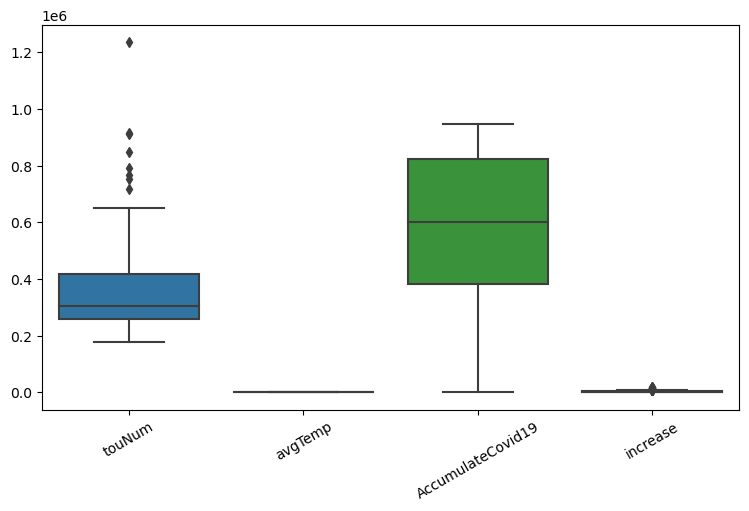

In [40]:
# 스케일링 전
plt.figure(figsize=(9, 5))
df_box = sns.boxplot(data=df_jeonju_col)
df_box.set_xticklabels(df_box.get_xticklabels(), rotation=30)
plt.show()

In [41]:
scaler = RobustScaler()
df_jeonju_scaling = scaler.fit_transform(df_jeonju_col)
df_jeonju_scaled = pd.DataFrame(df_jeonju_scaling, columns=df_jeonju_col.columns)
df_jeonju_scaled

,touNum,avgTemp,AccumulateCovid19,increase
0,0.875735,-0.863095,-1.353222,-0.602294
1,0.243242,-0.821429,-1.353127,-0.605046
2,-0.656041,-0.892857,-1.353047,-0.608257
3,-0.606718,-0.761905,-1.352943,-0.603211
4,-0.582469,-0.750000,-1.352807,-0.596789
...,...,...,...,...
360,0.000000,0.601190,0.211473,0.651835
361,0.000000,0.702381,0.211473,0.651835
362,0.000000,0.750000,0.211473,0.651835
363,0.000000,0.470238,0.395298,0.773853


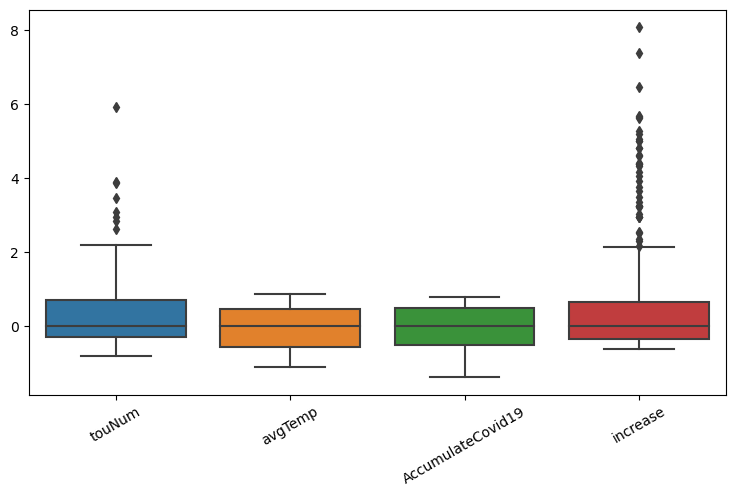

In [42]:
# 스케일링 후
plt.figure(figsize=(9, 5))
df_box2 = sns.boxplot(data=df_jeonju_scaled)
df_box2.set_xticklabels(df_box2.get_xticklabels(), rotation=30)
plt.show()

In [43]:
# 이상치 대체 함수
def replace_outliers_median(data, threshold=1):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    data[z_scores >= threshold] = np.median(data)
    return data
df_jeonju_outlier = replace_outliers_median(df_jeonju_scaled)

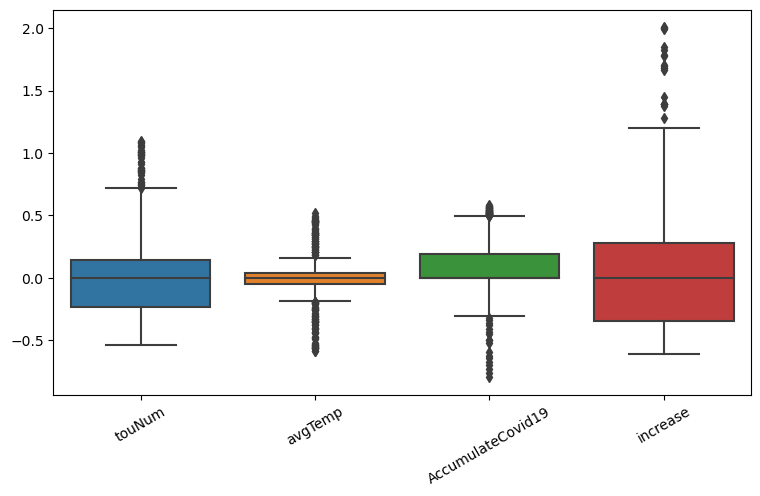

In [44]:
# 이상치 대체
plt.figure(figsize=(9, 5))
df_box3 = sns.boxplot(data=df_jeonju_outlier)
df_box3.set_xticklabels(df_box3.get_xticklabels(), rotation=30)
plt.show()

In [45]:
df_jeonju_outlier

,touNum,avgTemp,AccumulateCovid19,increase
0,0.875735,0.000000,0.000000,-0.602294
1,0.243242,0.000000,0.000000,-0.605046
2,0.000000,0.000000,0.000000,-0.608257
3,0.000000,0.000000,0.000000,-0.603211
4,0.000000,0.000000,0.000000,-0.596789
...,...,...,...,...
360,0.000000,0.000000,0.211473,0.651835
361,0.000000,0.000000,0.211473,0.651835
362,0.000000,0.000000,0.211473,0.651835
363,0.000000,0.470238,0.395298,0.773853


In [46]:
df_jeonju_drop = df_jeonju.drop(columns= ['touNum', 'avgTemp', 'AccumulateCovid19', 'increase', 'localIncrease', 'CovidForeigner'])
df_jeonju_drop.set_index([pd.Index(range(0, 365))], inplace=True)
df_jeonju = pd.concat([df_jeonju_outlier, df_jeonju_drop], axis=1)
df_jeonju.to_csv('./data/df_jeonju_final.csv', index=False, encoding='utf-8')
df_jeonju

,touNum,avgTemp,AccumulateCovid19,increase,baseYmd,festival_no,festival_yes,holiday_no,holiday_yes,PM10_no,PM10_yes,PM25_no,PM25_yes,dayRf_no,dayRf_yes
0,0.875735,0.000000,0.000000,-0.602294,2022-01-01,1,0,0,1,1,0,1,0,1,0
1,0.243242,0.000000,0.000000,-0.605046,2022-01-02,1,0,0,1,1,0,1,0,1,0
2,0.000000,0.000000,0.000000,-0.608257,2022-01-03,1,0,1,0,1,0,1,0,1,0
3,0.000000,0.000000,0.000000,-0.603211,2022-01-04,1,0,1,0,1,0,1,0,1,0
4,0.000000,0.000000,0.000000,-0.596789,2022-01-05,1,0,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.000000,0.000000,0.211473,0.651835,2022-08-18,1,0,1,0,1,0,1,0,1,0
361,0.000000,0.000000,0.211473,0.651835,2022-08-19,1,0,1,0,1,0,1,0,1,0
362,0.000000,0.000000,0.211473,0.651835,2022-08-20,1,0,0,1,1,0,1,0,0,1
363,0.000000,0.470238,0.395298,0.773853,2022-09-02,0,1,1,0,1,0,1,0,0,1


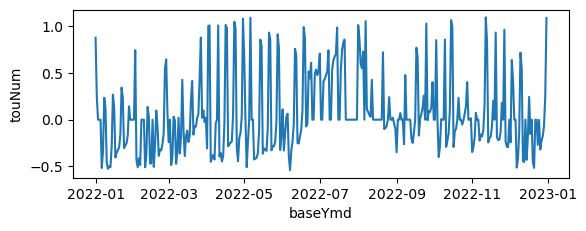

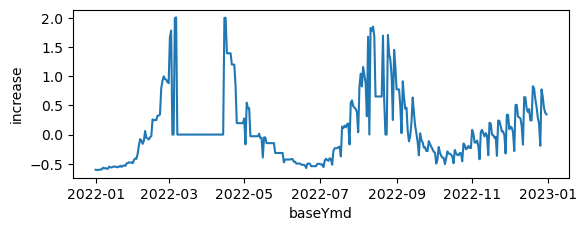

In [47]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_jeonju['baseYmd'], y=df_jeonju['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_jeonju['baseYmd'], y=df_jeonju['increase'])
plt.show()

- 부산광역시

In [48]:
df_busan.columns

Index(['touNum', 'baseYmd', 'avgTemp', 'AccumulateCovid19', 'increase',
       'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes',
       'holiday_no', 'holiday_yes', 'PM10_no', 'PM10_yes', 'PM25_no',
       'PM25_yes', 'dayRf_no', 'dayRf_yes'],
      dtype='object')

In [49]:
df_busan_col = df_busan.drop(columns=['baseYmd', 'dayRf_yes', 'dayRf_no', 'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes'])

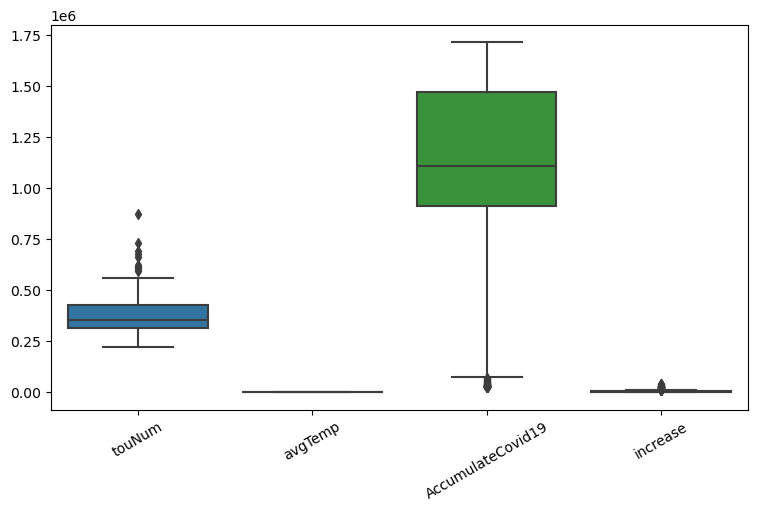

In [50]:
# 스케일링 전
plt.figure(figsize=(9, 5))
df_box = sns.boxplot(data=df_busan_col)
df_box.set_xticklabels(df_box.get_xticklabels(), rotation=30)
plt.show()

In [51]:
scaler = RobustScaler()
df_busan_scaling = scaler.fit_transform(df_busan_col)
df_busan_scaled = pd.DataFrame(df_busan_scaling, columns=df_busan_col.columns)
df_busan_scaled

,touNum,avgTemp,AccumulateCovid19,increase
0,0.830264,-1.034965,-1.929591,-0.582148
1,0.177786,-0.832168,-1.929206,-0.581095
2,-0.862148,-0.881119,-1.928898,-0.592417
3,-0.861134,-0.853147,-1.928639,-0.599789
4,-0.842910,-0.790210,-1.928184,-0.570827
...,...,...,...,...
360,0.000000,0.566434,0.322651,0.593470
361,0.000000,0.692308,0.322651,0.593470
362,0.000000,0.622378,0.322651,0.593470
363,0.000000,0.293706,0.527236,0.543707


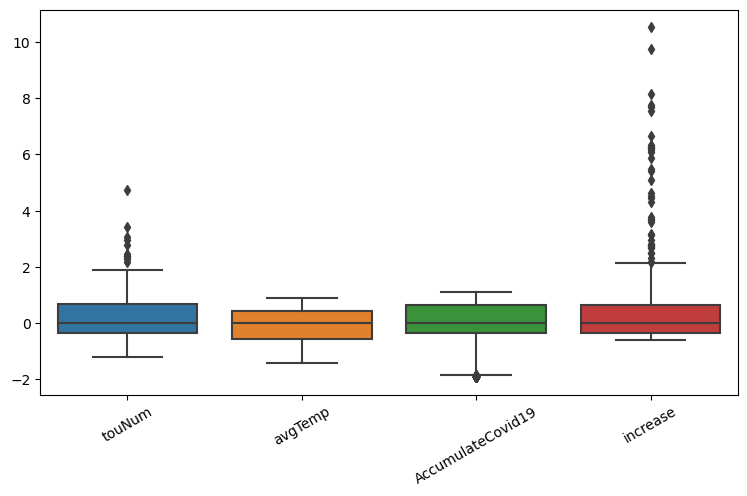

In [52]:
# 스케일링 후
plt.figure(figsize=(9, 5))
df_box2 = sns.boxplot(data=df_busan_scaled)
df_box2.set_xticklabels(df_box2.get_xticklabels(), rotation=30)
plt.show()

In [53]:
# 이상치 대체 함수
def replace_outliers_median(data, threshold=1):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    data[z_scores >= threshold] = np.median(data)
    return data
df_busan_outlier = replace_outliers_median(df_busan_scaled)

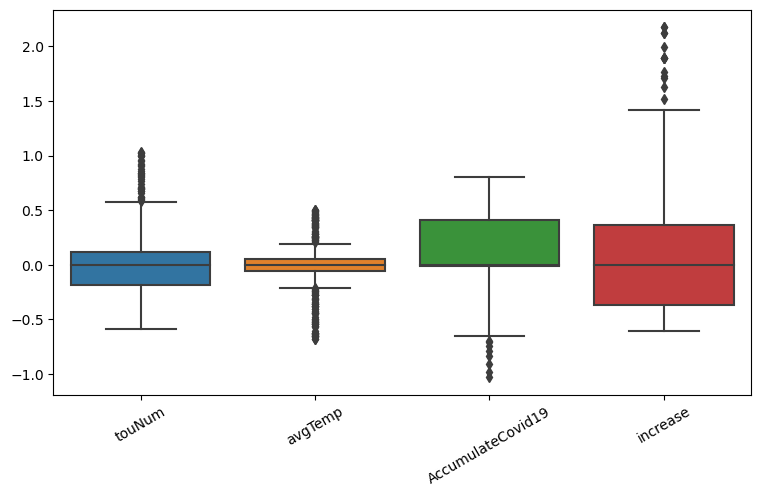

In [54]:
# 이상치 대체
plt.figure(figsize=(9, 5))
df_box3 = sns.boxplot(data=df_busan_outlier)
df_box3.set_xticklabels(df_box3.get_xticklabels(), rotation=30)
plt.show()

In [55]:
df_busan_outlier

,touNum,avgTemp,AccumulateCovid19,increase
0,0.830264,0.000000,0.000000,-0.582148
1,0.177786,0.000000,0.000000,-0.581095
2,0.000000,0.000000,0.000000,-0.592417
3,0.000000,0.000000,0.000000,-0.599789
4,0.000000,0.000000,0.000000,-0.570827
...,...,...,...,...
360,0.000000,0.000000,0.322651,0.593470
361,0.000000,0.000000,0.322651,0.593470
362,0.000000,0.000000,0.322651,0.593470
363,0.000000,0.293706,0.527236,0.543707


In [56]:
df_busan_drop = df_busan.drop(columns= ['touNum', 'avgTemp', 'AccumulateCovid19', 'increase', 'localIncrease', 'CovidForeigner'])
df_busan_drop.set_index([pd.Index(range(0, 365))], inplace=True)
df_busan = pd.concat([df_busan_outlier, df_busan_drop], axis=1)
df_busan.to_csv('./data/df_busan_final.csv', index=False, encoding='utf-8')
df_busan

,touNum,avgTemp,AccumulateCovid19,increase,baseYmd,festival_no,festival_yes,holiday_no,holiday_yes,PM10_no,PM10_yes,PM25_no,PM25_yes,dayRf_no,dayRf_yes
0,0.830264,0.000000,0.000000,-0.582148,2022-01-01,1,0,0,1,1,0,1,0,1,0
1,0.177786,0.000000,0.000000,-0.581095,2022-01-02,1,0,0,1,1,0,1,0,1,0
2,0.000000,0.000000,0.000000,-0.592417,2022-01-03,1,0,1,0,1,0,1,0,1,0
3,0.000000,0.000000,0.000000,-0.599789,2022-01-04,1,0,1,0,1,0,1,0,1,0
4,0.000000,0.000000,0.000000,-0.570827,2022-01-05,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.000000,0.000000,0.322651,0.593470,2022-08-18,1,0,1,0,1,0,1,0,1,0
361,0.000000,0.000000,0.322651,0.593470,2022-08-19,1,0,1,0,1,0,1,0,1,0
362,0.000000,0.000000,0.322651,0.593470,2022-08-20,1,0,0,1,1,0,1,0,0,1
363,0.000000,0.293706,0.527236,0.543707,2022-09-02,1,0,1,0,1,0,1,0,0,1


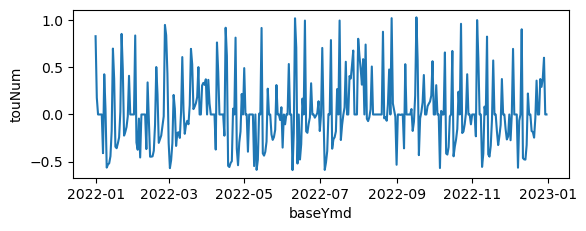

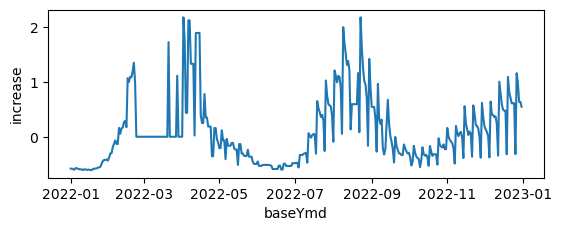

In [57]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_busan['baseYmd'], y=df_busan['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_busan['baseYmd'], y=df_busan['increase'])
plt.show()

- 충청북도

In [58]:
df_chungju.columns

Index(['touNum', 'baseYmd', 'avgTemp', 'AccumulateCovid19', 'increase',
       'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes',
       'holiday_no', 'holiday_yes', 'PM10_no', 'PM10_yes', 'PM25_no',
       'PM25_yes', 'dayRf_no', 'dayRf_yes'],
      dtype='object')

In [59]:
df_chungju_col = df_chungju.drop(columns=['baseYmd', 'dayRf_yes', 'dayRf_no', 'localIncrease', 'CovidForeigner', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes'])

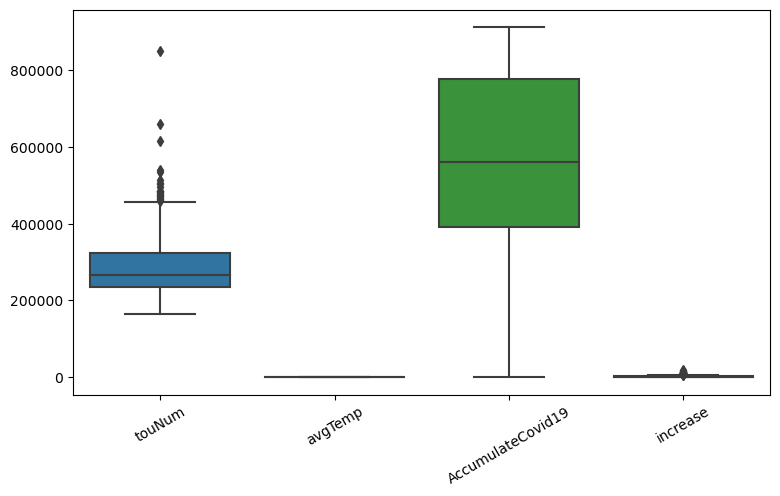

In [60]:
# 스케일링 전
plt.figure(figsize=(9, 5))
df_box = sns.boxplot(data=df_chungju_col)
df_box.set_xticklabels(df_box.get_xticklabels(), rotation=30)
plt.show()

In [61]:
scaler = RobustScaler()
df_chungju_scaling = scaler.fit_transform(df_chungju_col)
df_chungju_scaled = pd.DataFrame(df_chungju_scaling, columns=df_chungju_col.columns)
df_chungju_scaled

,touNum,avgTemp,AccumulateCovid19,increase
0,0.462892,-1.103825,-1.426087,-0.651649
1,-0.072893,-0.874317,-1.425958,-0.676730
2,-1.164211,-0.896175,-1.425836,-0.678124
3,-1.084663,-0.765027,-1.425678,-0.671621
4,-0.982641,-0.841530,-1.425501,-0.668370
...,...,...,...,...
360,0.000000,0.650273,0.253276,0.341384
361,0.000000,0.672131,0.253276,0.341384
362,0.000000,0.819672,0.253276,0.341384
363,0.000000,0.524590,0.423082,0.703669


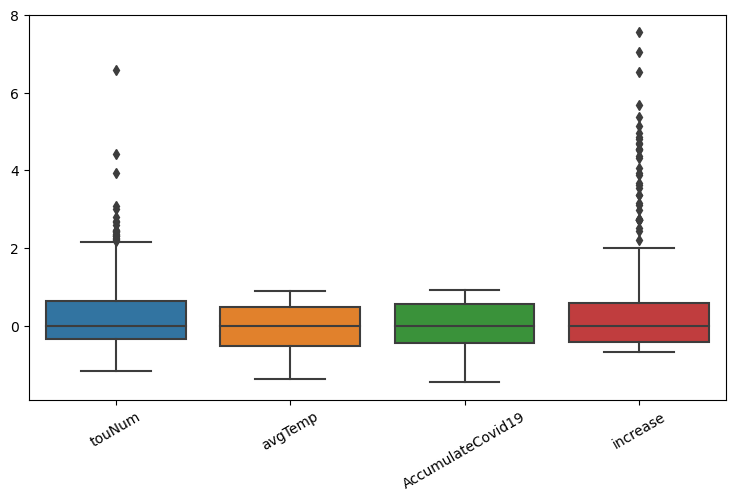

In [62]:
# 스케일링 후
plt.figure(figsize=(9, 5))
df_box2 = sns.boxplot(data=df_chungju_scaled)
df_box2.set_xticklabels(df_box2.get_xticklabels(), rotation=30)
plt.show()

In [63]:
# 이상치 대체 함수
def replace_outliers_median(data, threshold=1):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    data[z_scores >= threshold] = np.median(data)
    return data
df_chungju_outlier = replace_outliers_median(df_chungju_scaled)

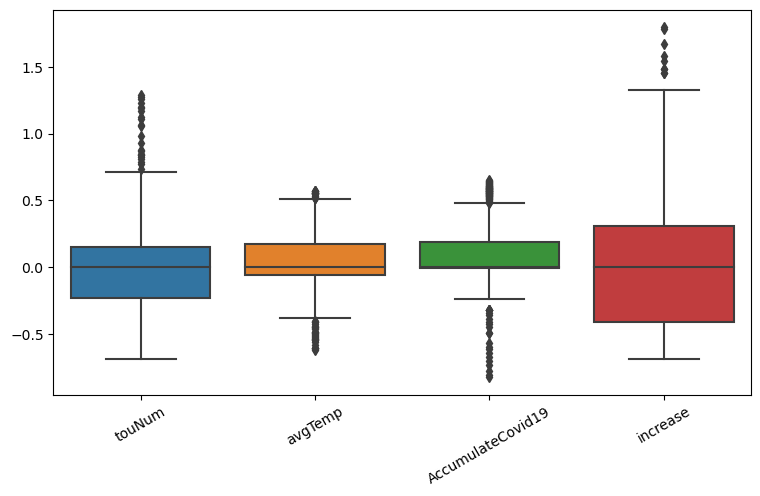

In [64]:
# 이상치 대체
plt.figure(figsize=(9, 5))
df_box3 = sns.boxplot(data=df_chungju_outlier)
df_box3.set_xticklabels(df_box3.get_xticklabels(), rotation=30)
plt.show()

In [65]:
df_chungju_outlier

,touNum,avgTemp,AccumulateCovid19,increase
0,0.462892,0.000000,0.000000,-0.651649
1,-0.072893,0.000000,0.000000,-0.676730
2,0.000000,0.000000,0.000000,-0.678124
3,0.000000,0.000000,0.000000,-0.671621
4,0.000000,0.000000,0.000000,-0.668370
...,...,...,...,...
360,0.000000,0.000000,0.253276,0.341384
361,0.000000,0.000000,0.253276,0.341384
362,0.000000,0.000000,0.253276,0.341384
363,0.000000,0.524590,0.423082,0.703669


In [66]:
df_chungju_drop = df_chungju.drop(columns= ['touNum', 'avgTemp', 'AccumulateCovid19', 'increase', 'localIncrease', 'CovidForeigner'])
df_chungju_drop.set_index([pd.Index(range(0, 365))], inplace=True)
df_chungju = pd.concat([df_chungju_outlier, df_chungju_drop], axis=1)
df_chungju.to_csv('./data/df_chungju_final.csv', index=False, encoding='utf-8')
df_chungju

,touNum,avgTemp,AccumulateCovid19,increase,baseYmd,festival_no,festival_yes,holiday_no,holiday_yes,PM10_no,PM10_yes,PM25_no,PM25_yes,dayRf_no,dayRf_yes
0,0.462892,0.000000,0.000000,-0.651649,2022-01-01,1,0,0,1,1,0,1,0,1,0
1,-0.072893,0.000000,0.000000,-0.676730,2022-01-02,1,0,0,1,1,0,1,0,1,0
2,0.000000,0.000000,0.000000,-0.678124,2022-01-03,1,0,1,0,1,0,1,0,1,0
3,0.000000,0.000000,0.000000,-0.671621,2022-01-04,1,0,1,0,1,0,1,0,1,0
4,0.000000,0.000000,0.000000,-0.668370,2022-01-05,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.000000,0.000000,0.253276,0.341384,2022-08-18,1,0,1,0,1,0,1,0,1,0
361,0.000000,0.000000,0.253276,0.341384,2022-08-19,1,0,1,0,1,0,1,0,0,1
362,0.000000,0.000000,0.253276,0.341384,2022-08-20,1,0,0,1,1,0,1,0,0,1
363,0.000000,0.524590,0.423082,0.703669,2022-09-02,0,1,1,0,1,0,1,0,1,0


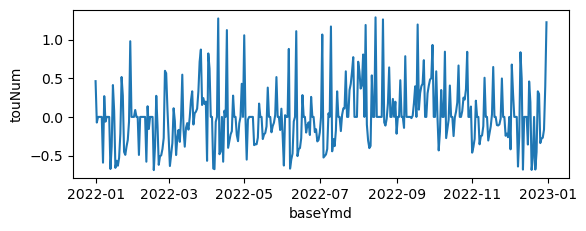

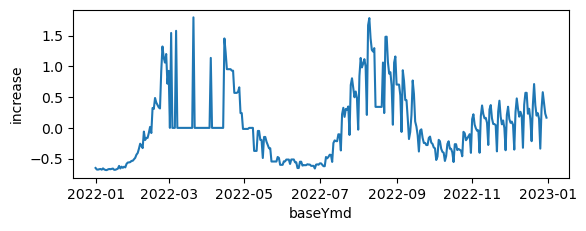

In [67]:
# 일별 관광객 그래프
plt.subplot(2,1,1)
sns.lineplot(x=df_chungju['baseYmd'], y=df_chungju['touNum'])
plt.show()

# 일별 확진자 그래프
plt.subplot(2,1,2)
sns.lineplot(x=df_chungju['baseYmd'], y=df_chungju['increase'])
plt.show()

### 5. 가설검정 (서울특별시, 제주특별자치도)

- 귀무가설 : 해외여행을 못 가게 되었지만, 코로나의 위험성에 국내 여행을 자제할 것이다.

- 대립가설 : 해외여행을 못 가게 된 사람들이 국내 여행을 많이 찾게 되면서 코로나 추세와는 상관없이 관광객이 많을 것이다.

- 서울특별시

<AxesSubplot:>

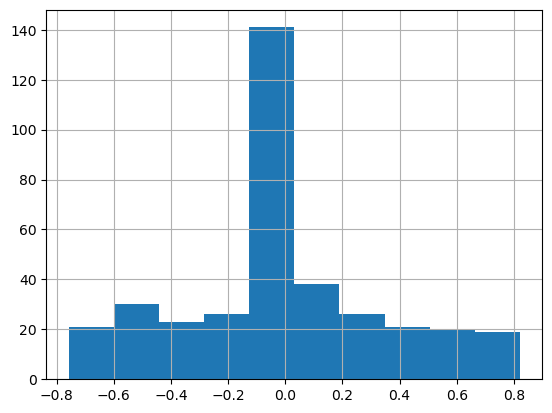

In [68]:
# 관광객수(정규분포)
df_seoul['touNum'].hist()

<AxesSubplot:>

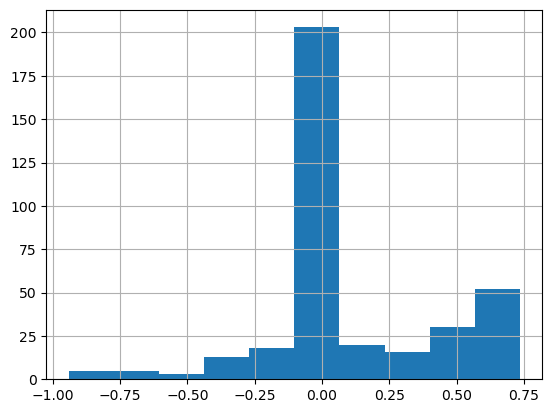

In [69]:
# 누적확진자수(비정규분포)
df_seoul['AccumulateCovid19'].hist()

In [70]:
df_seoul.columns

Index(['touNum', 'avgTemp', 'AccumulateCovid19', 'increase', 'baseYmd',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes', 'dayRf_no', 'dayRf_yes'],
      dtype='object')

In [72]:
# 독립변수와 종속변수 나누어 저장
dfX_seoul = df_seoul.drop(columns=['touNum', 'baseYmd'])
dfy_seoul = df_seoul.drop(columns=['baseYmd', 'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no', 'dayRf_yes', 'dayRf_no',
       'PM10_yes', 'PM25_no', 'PM25_yes', 'avgTemp', 'AccumulateCovid19', 'increase'])

In [73]:
dfXy_seoul = pd.concat([dfX_seoul, dfy_seoul], axis=1)

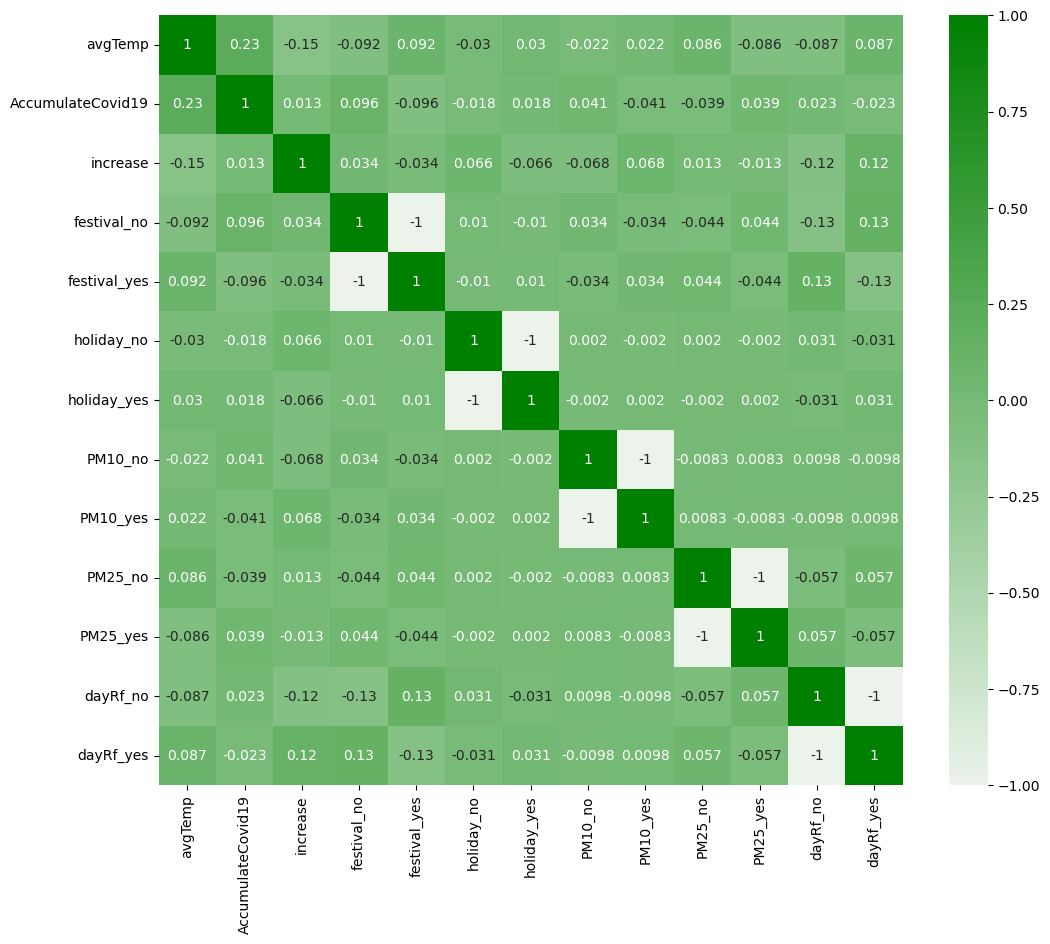

In [74]:
plt.figure(figsize=(12, 10))
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(dfX_seoul.corr(), annot=True, cmap=cmap)
plt.show()

In [75]:
# 서울특별시 다중공선성 조사
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(dfX_seoul.values, i) for i in range(dfX_seoul.shape[1])]
vif["변수"] = dfX_seoul.columns
vif = vif.sort_values("VIF").reset_index(drop=True)
vif

,VIF,변수
0,1.057253,increase
1,1.083633,AccumulateCovid19
2,1.127239,avgTemp
3,inf,festival_no
4,inf,festival_yes
5,inf,holiday_no
6,inf,holiday_yes
7,inf,PM10_no
8,inf,PM10_yes
9,inf,PM25_no


In [76]:
# 학습용 7 : 검증용 3 dayRf + daySf + festival_no + festival_yes + holiday_no + holiday_yes + PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp + AccumulateCovid19 + increase
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ " + "+".join(dfX_seoul.columns), data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     3.825
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           0.000294
Time:                        16:36:22   Log-Likelihood:                -90.001
No. Observations:                 255   AIC:                             198.0
Df Residuals:                     246   BIC:                             229.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0343      0.047     -0.738      0.461      -0.126       0.057
avgTemp               0.3405      0.094      3.632      0.000       0.156       0.525
AccumulateCovid19    -0.0084      0.073     -0.115      0.909      -0.152       0.136
increase              0.1274      0.051      2.488      0.014       0.027       0.228
festival_no          -0.0380      0.034     -1.114      0.266      -0.105       0.029
festival_yes          0.0037      0.039      0.094      0.925      -0.073       0.080
holiday_no           -0.0981      0.033     -2.984      0.003      -0.163      -0.033
holiday_yes           0.0638      0.034      1.899      0.059      -0.002       0.130
PM10_no               0.0442      0.090      0.489      0.625      -0.134       0.222
PM10_yes             -0.0785      0.118     -0.665      0.507      -0.311       0.154
PM25_no               0.0727      0.109      0.667      0.505      -0.142       0.287
PM25_yes             -0.1070      0.144     -0.741      0.460      -0.392       0.178
dayRf_no              0.0333      0.033      1.006      0.316      -0.032       0.099
dayRf_yes            -0.0677      0.038     -1.801      0.073      -0.142       0.006
==============================================================================
Omnibus:                        1.405   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.495   Jarque-Bera (JB):                1.439
Skew:                           0.117   Prob(JB):                        0.487
Kurtosis:                       2.716   Cond. No.                     1.26e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.9e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [78]:
# 미세먼지 제거 + PM10_no + PM10_yes + PM25_no + PM25_yes 
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ dayRf_yes + dayRf_no + festival_no + festival_yes + holiday_no + holiday_yes + avgTemp + AccumulateCovid19 + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     4.978
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           7.81e-05
Time:                        16:36:46   Log-Likelihood:                -90.450
No. Observations:                 255   AIC:                             194.9
Df Residuals:                     248   BIC:                             219.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0113      0.014      0.832      0.406      -0.015       0.038
dayRf_yes            -0.0443      0.031     -1.450      0.148      -0.105       0.016
dayRf_no              0.0556      0.024      2.321      0.021       0.008       0.103
festival_no          -0.0156      0.025     -0.624      0.533      -0.065       0.034
festival_yes          0.0269      0.032      0.832      0.406      -0.037       0.091
holiday_no           -0.0747      0.023     -3.239      0.001      -0.120      -0.029
holiday_yes           0.0860      0.026      3.295      0.001       0.035       0.137
avgTemp               0.3455      0.093      3.723      0.000       0.163       0.528
AccumulateCovid19    -0.0055      0.073     -0.075      0.940      -0.149       0.138
increase              0.1264      0.051      2.489      0.013       0.026       0.226
==============================================================================
Omnibus:                        1.371   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.504   Jarque-Bera (JB):                1.397
Skew:                           0.109   Prob(JB):                        0.497
Kurtosis:                       2.710   Cond. No.                     1.75e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.45e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [79]:
# 공휴일 제거 + holiday_no + holiday_yes 
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ dayRf_yes + dayRf_no + festival_no + festival_yes + PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp + AccumulateCovid19 + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     2.598
Date:                Wed, 29 Mar 2023   Prob (F-statistic):             0.0133
Time:                        16:37:08   Log-Likelihood:                -95.891
No. Observations:                 255   AIC:                             207.8
Df Residuals:                     247   BIC:                             236.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0440      0.055     -0.794      0.428      -0.153       0.065
dayRf_yes            -0.0680      0.041     -1.647      0.101      -0.149       0.013
dayRf_no              0.0240      0.036      0.660      0.510      -0.048       0.096
festival_no          -0.0403      0.037     -1.083      0.280      -0.114       0.033
festival_yes         -0.0037      0.042     -0.087      0.931      -0.087       0.080
PM10_no               0.0355      0.091      0.391      0.696      -0.143       0.214
PM10_yes             -0.0795      0.124     -0.643      0.521      -0.323       0.164
PM25_no               0.0565      0.109      0.520      0.604      -0.157       0.270
PM25_yes             -0.1005      0.151     -0.666      0.506      -0.398       0.197
avgTemp               0.3325      0.096      3.473      0.001       0.144       0.521
AccumulateCovid19    -0.0200      0.075     -0.269      0.788      -0.167       0.127
increase              0.1070      0.052      2.061      0.040       0.005       0.209
==============================================================================
Omnibus:                        0.168   Durbin-Watson:                   2.173
Prob(Omnibus):                  0.920   Jarque-Bera (JB):                0.303
Skew:                           0.027   Prob(JB):                        0.860
Kurtosis:                       2.840   Cond. No.                     3.34e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.9e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [80]:
# 코로나 제거 + AccumulateCovid19 + increase
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ dayRf_yes + dayRf_no + holiday_no + holiday_yes + festival_no + festival_yes+ PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.000
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           0.000766
Time:                        16:37:19   Log-Likelihood:                -93.170
No. Observations:                 255   AIC:                             200.3
Df Residuals:                     248   BIC:                             225.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0325      0.047     -0.693      0.489      -0.125       0.060
dayRf_yes       -0.0602      0.038     -1.594      0.112      -0.135       0.014
dayRf_no         0.0277      0.033      0.831      0.407      -0.038       0.093
holiday_no      -0.0904      0.033     -2.739      0.007      -0.155      -0.025
holiday_yes      0.0579      0.034      1.714      0.088      -0.009       0.124
festival_no     -0.0369      0.034     -1.078      0.282      -0.104       0.031
festival_yes     0.0044      0.039      0.113      0.910      -0.072       0.081
PM10_no          0.0211      0.091      0.234      0.815      -0.157       0.199
PM10_yes        -0.0536      0.119     -0.453      0.651      -0.287       0.180
PM25_no          0.0897      0.110      0.818      0.414      -0.126       0.306
PM25_yes        -0.1222      0.146     -0.840      0.402      -0.409       0.164
avgTemp          0.2896      0.090      3.208      0.002       0.112       0.467
==============================================================================
Omnibus:                        3.576   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                2.990
Skew:                           0.163   Prob(JB):                        0.224
Kurtosis:                       2.582   Cond. No.                     1.35e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.85e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [81]:
# 날씨 제거 + avgTemp + dayRf_yes + dayRf_no
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ holiday_no + holiday_yes + festival_no + festival_yes+ PM10_no + PM10_yes + PM25_no + PM25_yes + AccumulateCovid19 + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.322
Date:                Wed, 29 Mar 2023   Prob (F-statistic):             0.0336
Time:                        16:37:31   Log-Likelihood:                -97.980
No. Observations:                 255   AIC:                             210.0
Df Residuals:                     248   BIC:                             234.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0401      0.055     -0.726      0.468      -0.149       0.069
holiday_no           -0.0969      0.036     -2.668      0.008      -0.169      -0.025
holiday_yes           0.0568      0.037      1.524      0.129      -0.017       0.130
festival_no          -0.0551      0.037     -1.478      0.141      -0.129       0.018
festival_yes          0.0150      0.042      0.359      0.720      -0.067       0.097
PM10_no               0.0266      0.091      0.293      0.770      -0.152       0.205
PM10_yes             -0.0667      0.124     -0.537      0.592      -0.311       0.178
PM25_no               0.1119      0.108      1.031      0.303      -0.102       0.326
PM25_yes             -0.1520      0.150     -1.010      0.313      -0.448       0.144
AccumulateCovid19     0.0446      0.073      0.607      0.544      -0.100       0.189
increase              0.0804      0.051      1.570      0.118      -0.020       0.181
==============================================================================
Omnibus:                        1.494   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.474   Jarque-Bera (JB):                1.573
Skew:                           0.148   Prob(JB):                        0.456
Kurtosis:                       2.755   Cond. No.                     2.09e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.48e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [83]:
# 축제 제거  + festival_no + festival_yes  
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ holiday_no + holiday_yes + avgTemp + dayRf_yes + dayRf_no + PM10_no + PM10_yes + PM25_no + PM25_yes + AccumulateCovid19 + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     4.301
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           0.000164
Time:                        16:37:46   Log-Likelihood:                -90.284
No. Observations:                 255   AIC:                             196.6
Df Residuals:                     247   BIC:                             224.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0453      0.054     -0.843      0.400      -0.151       0.061
holiday_no           -0.1032      0.036     -2.904      0.004      -0.173      -0.033
holiday_yes           0.0578      0.036      1.599      0.111      -0.013       0.129
avgTemp               0.3446      0.094      3.685      0.000       0.160       0.529
dayRf_yes            -0.0768      0.039     -1.944      0.053      -0.155       0.001
dayRf_no              0.0314      0.036      0.883      0.378      -0.039       0.101
PM10_no               0.0361      0.088      0.408      0.684      -0.138       0.210
PM10_yes             -0.0814      0.121     -0.674      0.501      -0.319       0.157
PM25_no               0.0718      0.106      0.675      0.500      -0.138       0.281
PM25_yes             -0.1171      0.147     -0.795      0.427      -0.407       0.173
AccumulateCovid19    -0.0145      0.073     -0.199      0.842      -0.157       0.129
increase              0.1272      0.051      2.487      0.014       0.026       0.228
==============================================================================
Omnibus:                        1.451   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.484   Jarque-Bera (JB):                1.507
Skew:                           0.132   Prob(JB):                        0.471
Kurtosis:                       2.732   Cond. No.                     1.20e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.4e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [85]:
# 조정된 R 값이 상승하는 변수만 삭제 
def get_model1(seed):
    df_train_seoul, df_test_seoul = train_test_split(df_seoul, test_size=0.3, random_state=seed)
    model1_seoul = sm.OLS.from_formula("touNum ~ holiday_no + holiday_yes + avgTemp + dayRf_yes + dayRf_no + AccumulateCovid19 + increase", data = df_train_seoul)
    return df_train_seoul, df_test_seoul, model1_seoul.fit()

df_train_seoul, df_test_seoul, result_seoul = get_model1(3)
result_seoul.summary()

# 영향력이 없는 변수들 PM10_no + PM10_yes + PM25_no + PM25_yes + festival_no + festival_yes

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     5.869
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           3.80e-05
Time:                        16:38:14   Log-Likelihood:                -90.744
No. Observations:                 255   AIC:                             193.5
Df Residuals:                     249   BIC:                             214.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0070      0.014      0.498      0.619      -0.021       0.035
holiday_no           -0.0763      0.023     -3.342      0.001      -0.121      -0.031
holiday_yes           0.0834      0.026      3.160      0.002       0.031       0.135
avgTemp               0.3502      0.092      3.786      0.000       0.168       0.532
dayRf_yes            -0.0501      0.030     -1.655      0.099      -0.110       0.010
dayRf_no              0.0571      0.024      2.425      0.016       0.011       0.103
AccumulateCovid19    -0.0118      0.072     -0.163      0.871      -0.154       0.131
increase              0.1265      0.051      2.492      0.013       0.027       0.226
==============================================================================
Omnibus:                        1.398   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.497   Jarque-Bera (JB):                1.446
Skew:                           0.123   Prob(JB):                        0.485
Kurtosis:                       2.725   Cond. No.                     4.92e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.39e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [86]:
# 교차 검증
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(dfXy_seoul)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]

    model = sm.OLS.from_formula("touNum ~" + "+".join(dfX_seoul.columns), data=df_seoul)
    result = model.fit()

    pred = result.predict(df_test)
    rss = ((df_test.touNum - pred) ** 2).sum()
    tss = ((df_test.touNum - df_test.touNum.mean()) ** 2).sum()
    rsquared = 1 - rss / tss

    scores[i] = rsquared
    print(f"학습용 R2 = {result.rsquared:.3f}, 검증용 R2 = {result.rsquared:.3f}")

학습용 R2 = 0.105, 검증용 R2 = 0.105
학습용 R2 = 0.105, 검증용 R2 = 0.105
학습용 R2 = 0.105, 검증용 R2 = 0.105
학습용 R2 = 0.105, 검증용 R2 = 0.105
학습용 R2 = 0.105, 검증용 R2 = 0.105


- 제주특별자치도

In [87]:
df_jeju.columns

Index(['touNum', 'avgTemp', 'AccumulateCovid19', 'increase', 'baseYmd',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes', 'dayRf_no', 'dayRf_yes'],
      dtype='object')

In [88]:
# 독립변수와 종속변수 나누어 저장
dfX_jeju = df_jeju.drop(columns=['touNum', 'baseYmd'])
dfy_jeju = df_jeju.drop(columns=['avgTemp', 'AccumulateCovid19', 'increase', 'baseYmd',
       'festival_no', 'festival_yes', 'holiday_no', 'holiday_yes', 'PM10_no',
       'PM10_yes', 'PM25_no', 'PM25_yes', 'dayRf_no', 'dayRf_yes'])

In [89]:
dfXy_jeju = pd.concat([dfX_jeju, dfy_jeju], axis=1)

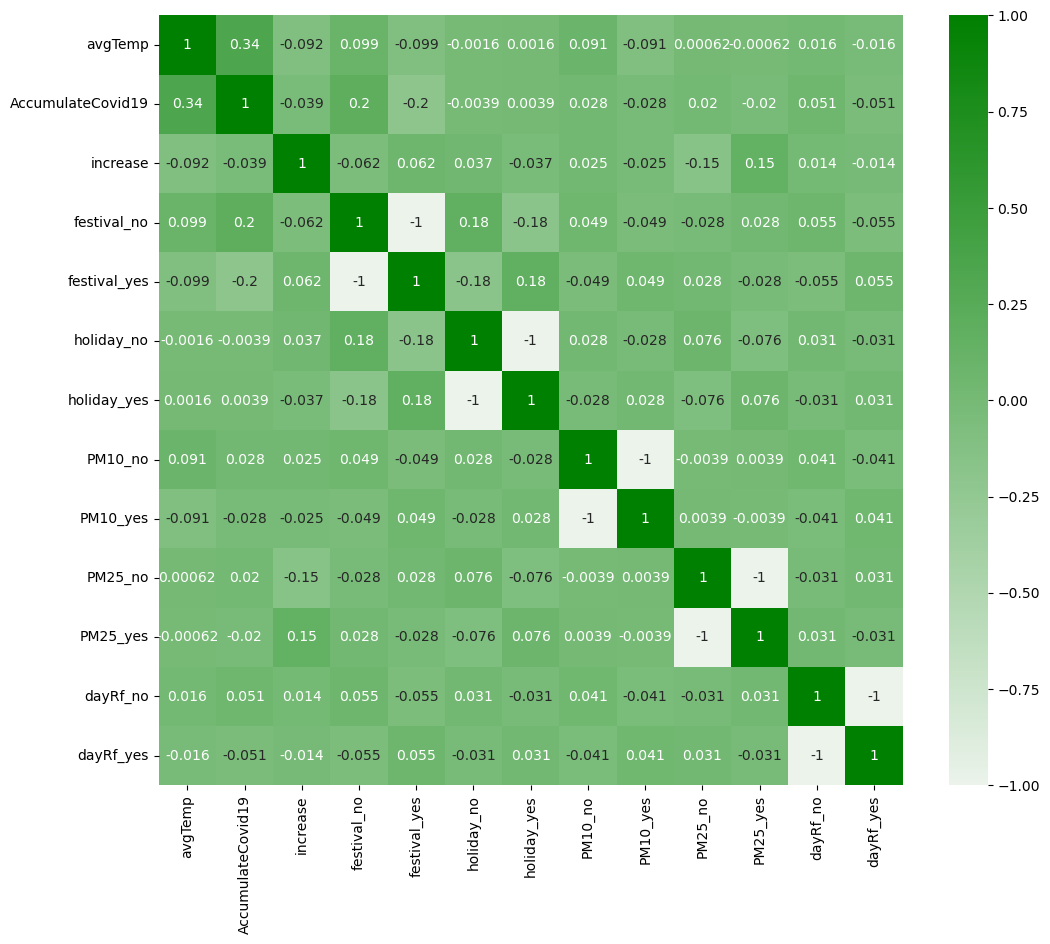

In [90]:
plt.figure(figsize=(12, 10))
cmap = sns.light_palette("green", as_cmap=True)
sns.heatmap(dfX_jeju.corr(), annot=True, cmap=cmap)
plt.show()

In [91]:
# 제주특별자치도 다중공선성 조사
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(dfX_seoul.values, i) for i in range(dfX_jeju.shape[1])]
vif["변수"] = dfX_jeju.columns
vif = vif.sort_values("VIF").reset_index(drop=True)
vif

,VIF,변수
0,1.057253,increase
1,1.083633,AccumulateCovid19
2,1.127239,avgTemp
3,inf,festival_no
4,inf,festival_yes
5,inf,holiday_no
6,inf,holiday_yes
7,inf,PM10_no
8,inf,PM10_yes
9,inf,PM25_no


In [92]:
# 학습용 7 : 검증용 3 dayRf + daySf + festival_no + festival_yes + holiday_no + holiday_yes + PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp + AccumulateCovid19 + increase
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ " + "+".join(dfX_jeju.columns), data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     6.579
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           8.79e-08
Time:                        16:41:58   Log-Likelihood:                -91.966
No. Observations:                 255   AIC:                             201.9
Df Residuals:                     246   BIC:                             233.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0382      0.063      0.604      0.546      -0.086       0.163
avgTemp               0.3553      0.097      3.675      0.000       0.165       0.546
AccumulateCovid19     0.3339      0.077      4.356      0.000       0.183       0.485
increase              0.1028      0.050      2.061      0.040       0.005       0.201
festival_no           0.0140      0.040      0.349      0.727      -0.065       0.093
festival_yes          0.0243      0.043      0.558      0.577      -0.061       0.110
holiday_no           -0.0059      0.041     -0.143      0.886      -0.088       0.076
holiday_yes           0.0442      0.038      1.154      0.250      -0.031       0.120
PM10_no              -0.0824      0.112     -0.733      0.464      -0.304       0.139
PM10_yes              0.1206      0.147      0.823      0.411      -0.168       0.409
PM25_no              -0.1107      0.157     -0.706      0.481      -0.420       0.198
PM25_yes              0.1489      0.208      0.715      0.476      -0.262       0.559
dayRf_no              0.0681      0.040      1.714      0.088      -0.010       0.146
dayRf_yes            -0.0299      0.042     -0.715      0.475      -0.112       0.052
==============================================================================
Omnibus:                        0.911   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.625
Skew:                           0.019   Prob(JB):                        0.732
Kurtosis:                       3.240   Cond. No.                     1.05e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.13e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [93]:
# 미세먼지 제거 + PM10_no + PM10_yes + PM25_no + PM25_yes 
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ dayRf_yes + dayRf_no + festival_no + festival_yes + holiday_no + holiday_yes + avgTemp + AccumulateCovid19 + increase", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     8.609
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.64e-08
Time:                        16:42:21   Log-Likelihood:                -92.563
No. Observations:                 255   AIC:                             199.1
Df Residuals:                     248   BIC:                             223.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0378      0.012     -3.050      0.003      -0.062      -0.013
dayRf_yes            -0.0674      0.029     -2.349      0.020      -0.124      -0.011
dayRf_no              0.0296      0.024      1.238      0.217      -0.017       0.077
festival_no          -0.0236      0.026     -0.924      0.356      -0.074       0.027
festival_yes         -0.0142      0.030     -0.474      0.636      -0.073       0.045
holiday_no           -0.0464      0.024     -1.943      0.053      -0.093       0.001
holiday_yes           0.0086      0.026      0.331      0.741      -0.042       0.060
avgTemp               0.3482      0.096      3.630      0.000       0.159       0.537
AccumulateCovid19     0.3328      0.077      4.350      0.000       0.182       0.483
increase              0.1082      0.049      2.218      0.027       0.012       0.204
==============================================================================
Omnibus:                        0.726   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.695   Jarque-Bera (JB):                0.451
Skew:                          -0.001   Prob(JB):                        0.798
Kurtosis:                       3.206   Cond. No.                     6.73e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.65e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [94]:
# 공휴일 제거 + holiday_no + holiday_yes 
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ dayRf_yes + dayRf_no + festival_no + festival_yes + PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp + AccumulateCovid19 + increase", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     7.366
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           4.90e-08
Time:                        16:42:26   Log-Likelihood:                -92.515
No. Observations:                 255   AIC:                             201.0
Df Residuals:                     247   BIC:                             229.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0508      0.074      0.691      0.490      -0.094       0.196
dayRf_yes            -0.0234      0.046     -0.510      0.611      -0.114       0.067
dayRf_no              0.0742      0.044      1.695      0.091      -0.012       0.160
festival_no           0.0152      0.044      0.346      0.730      -0.071       0.102
festival_yes          0.0356      0.047      0.757      0.450      -0.057       0.128
PM10_no              -0.0791      0.111     -0.715      0.475      -0.297       0.139
PM10_yes              0.1299      0.150      0.865      0.388      -0.166       0.426
PM25_no              -0.1255      0.152     -0.826      0.410      -0.425       0.174
PM25_yes              0.1763      0.212      0.833      0.406      -0.241       0.593
avgTemp               0.3575      0.097      3.699      0.000       0.167       0.548
AccumulateCovid19     0.3307      0.077      4.317      0.000       0.180       0.482
increase              0.0984      0.050      1.981      0.049       0.001       0.196
==============================================================================
Omnibus:                        0.911   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.624
Skew:                           0.030   Prob(JB):                        0.732
Kurtosis:                       3.235   Cond. No.                     5.97e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.09e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [95]:
# 코로나 제거 + AccumulateCovid19 + increase
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ dayRf_yes + dayRf_no + holiday_no + holiday_yes + festival_no + festival_yes+ PM10_no + PM10_yes + PM25_no + PM25_yes + avgTemp", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.512
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           0.000232
Time:                        16:42:31   Log-Likelihood:                -103.48
No. Observations:                 255   AIC:                             221.0
Df Residuals:                     248   BIC:                             245.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0637      0.065      0.981      0.327      -0.064       0.192
dayRf_yes       -0.0143      0.043     -0.332      0.740      -0.099       0.071
dayRf_no         0.0781      0.041      1.906      0.058      -0.003       0.159
holiday_no       0.0153      0.042      0.360      0.719      -0.068       0.099
holiday_yes      0.0484      0.040      1.219      0.224      -0.030       0.127
festival_no      0.0397      0.041      0.962      0.337      -0.042       0.121
festival_yes     0.0240      0.044      0.540      0.590      -0.064       0.112
PM10_no         -0.0618      0.117     -0.531      0.596      -0.291       0.168
PM10_yes         0.1256      0.153      0.823      0.412      -0.175       0.426
PM25_no         -0.1516      0.160     -0.946      0.345      -0.467       0.164
PM25_yes         0.2153      0.213      1.012      0.313      -0.204       0.635
avgTemp          0.4529      0.096      4.705      0.000       0.263       0.642
==============================================================================
Omnibus:                        2.219   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.330   Jarque-Bera (JB):                1.940
Skew:                           0.131   Prob(JB):                        0.379
Kurtosis:                       3.338   Cond. No.                     4.35e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.55e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [96]:
# 날씨 제거 + avgTemp + dayRf_yes + dayRf_no
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ holiday_no + holiday_yes + festival_no + festival_yes+ PM10_no + PM10_yes + PM25_no + PM25_yes + AccumulateCovid19 + increase", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     5.609
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.77e-05
Time:                        16:42:41   Log-Likelihood:                -100.46
No. Observations:                 255   AIC:                             214.9
Df Residuals:                     248   BIC:                             239.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0377      0.076      0.497      0.619      -0.112       0.187
holiday_no           -0.0079      0.047     -0.168      0.867      -0.101       0.085
holiday_yes           0.0456      0.044      1.043      0.298      -0.040       0.132
festival_no           0.0219      0.045      0.485      0.628      -0.067       0.111
festival_yes          0.0158      0.049      0.322      0.748      -0.081       0.112
PM10_no              -0.0208      0.113     -0.185      0.854      -0.243       0.202
PM10_yes              0.0585      0.154      0.380      0.704      -0.244       0.361
PM25_no              -0.1331      0.157     -0.846      0.398      -0.443       0.177
PM25_yes              0.1708      0.219      0.779      0.437      -0.261       0.602
AccumulateCovid19     0.4070      0.076      5.372      0.000       0.258       0.556
increase              0.0865      0.051      1.694      0.092      -0.014       0.187
==============================================================================
Omnibus:                        1.902   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.652
Skew:                          -0.190   Prob(JB):                        0.438
Kurtosis:                       3.105   Cond. No.                     2.91e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [97]:
# 축제 제거  + festival_no + festival_yes  
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ holiday_no + holiday_yes + avgTemp + dayRf_yes + dayRf_no + PM10_no + PM10_yes + PM25_no + PM25_yes + AccumulateCovid19 + increase", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     7.543
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           3.07e-08
Time:                        16:42:48   Log-Likelihood:                -91.984
No. Observations:                 255   AIC:                             200.0
Df Residuals:                     247   BIC:                             228.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0434      0.073      0.592      0.555      -0.101       0.188
holiday_no           -0.0042      0.045     -0.092      0.926      -0.093       0.085
holiday_yes           0.0476      0.042      1.123      0.263      -0.036       0.131
avgTemp               0.3543      0.096      3.678      0.000       0.165       0.544
dayRf_yes            -0.0270      0.046     -0.588      0.557      -0.118       0.063
dayRf_no              0.0704      0.044      1.617      0.107      -0.015       0.156
PM10_no              -0.0807      0.110     -0.733      0.464      -0.298       0.136
PM10_yes              0.1241      0.150      0.828      0.409      -0.171       0.419
PM25_no              -0.1058      0.152     -0.694      0.488      -0.406       0.194
PM25_yes              0.1492      0.212      0.704      0.482      -0.268       0.567
AccumulateCovid19     0.3318      0.076      4.383      0.000       0.183       0.481
increase              0.1035      0.050      2.085      0.038       0.006       0.201
==============================================================================
Omnibus:                        0.832   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.548
Skew:                           0.020   Prob(JB):                        0.760
Kurtosis:                       3.224   Cond. No.                     3.89e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.13e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [98]:
# 조정된 R 값이 상승하는 변수만 삭제 
def get_model1(seed):
    df_train_jeju, df_test_jeju = train_test_split(df_jeju, test_size=0.3, random_state=seed)
    model1_jeju = sm.OLS.from_formula("touNum ~ avgTemp + dayRf_yes + dayRf_no + AccumulateCovid19 + increase", data = df_train_jeju)
    return df_train_jeju, df_test_jeju, model1_jeju.fit()

df_train_jeju, df_test_jeju, result_jeju = get_model1(3)
result_jeju.summary()

# 영향력이 없는 변수들 holiday_no + holiday_yes + festival_no + festival_yes + PM10_no + PM10_yes + PM25_no + PM25_yes + 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 touNum   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     12.58
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           2.42e-09
Time:                        16:43:01   Log-Likelihood:                -93.301
No. Observations:                 255   AIC:                             196.6
Df Residuals:                     250   BIC:                             214.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0701      0.019     -3.775      0.000      -0.107      -0.034
avgTemp               0.3485      0.096      3.644      0.000       0.160       0.537
dayRf_yes            -0.0828      0.031     -2.669      0.008      -0.144      -0.022
dayRf_no              0.0127      0.023      0.559      0.577      -0.032       0.058
AccumulateCovid19     0.3246      0.075      4.303      0.000       0.176       0.473
increase              0.1055      0.049      2.173      0.031       0.010       0.201
==============================================================================
Omnibus:                        0.544   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.294
Skew:                           0.015   Prob(JB):                        0.863
Kurtosis:                       3.164   Cond. No.                     3.39e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.76e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [99]:
# 교차 검증
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(dfXy_jeju)):
    df_train = df.iloc[idx_train]
    df_test = df.iloc[idx_test]

    model = sm.OLS.from_formula("touNum ~" + "+".join(dfX_jeju.columns), data=df_jeju)
    result = model.fit()

    pred = result.predict(df_test)
    rss = ((df_test.touNum - pred) ** 2).sum()
    tss = ((df_test.touNum - df_test.touNum.mean()) ** 2).sum()
    rsquared = 1 - rss / tss

    scores[i] = rsquared
    print(f"학습용 R2 = {result.rsquared:.3f}, 검증용 R2 = {result.rsquared:.3f}")

학습용 R2 = 0.178, 검증용 R2 = 0.178
학습용 R2 = 0.178, 검증용 R2 = 0.178
학습용 R2 = 0.178, 검증용 R2 = 0.178
학습용 R2 = 0.178, 검증용 R2 = 0.178
학습용 R2 = 0.178, 검증용 R2 = 0.178
